In [42]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.signal import find_peaks
import scipy.signal as signal
import traceback
import pandas as pd

%matplotlib widget

mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["DejaVu Sans"]
plt.rcParams["font.size"] = 10

#mpl.rcParams["axes.spines.right"] = False
#mpl.rcParams["axes.spines.top"] = False

save_dir = 'results'

In [43]:
#where txt files are kept
txt_files = '/Users/csengi/Documents/CsengeR-CA3PC/CaSpikes/txt_traces_fixed/'
#load duration databse (aka table with calculated spike start and end times)
df = pd.read_excel("/Users/csengi/Documents/CsengeR-CA3PC/duration_database.xlsx")

cell_name_list      = df["cell_name"].tolist()
file_name_list      = df["full_file_name"].tolist()
drug_list           = df["drug"].tolist()
stim_list           = df["stim"].tolist()
parameter_list      = df["parameter"].tolist()
spike_start_list    = df["spike_start"].tolist()
spike_end_list      = df["spike_end"].tolist()
exclude_list        = df["exclude?"].tolist()

In [44]:
# gaussian filter
def gaussian_filter(trace, delta_t, sdfilt, N): #delta_t = time between data points,
                                                #sdfilt = standard deviation of filter
                                                #N = how many sd wide filter is
    sd = sdfilt / delta_t #convert from time to data points

    if int(N * sd) == 0: #checks if filter is too small to be meaningful
        return trace

    x_filt = np.arange(int(-N * sd), int(N * sd) + 1) #creates a vector from interval
    filt = np.exp(-(x_filt ** 2) / (2 * sd ** 2)) #G(x) = e^(-(x^2) / (2 * sd^2))
    filt /= filt.sum() #ensure that all weights add up to 1

    padded = np.hstack([ #repeating signal at beginning and end
        np.repeat(trace[0], int(N * sd)),
        trace,
        np.repeat(trace[-1], int(N * sd))
    ])

    result = np.convolve(padded, filt, mode='valid')
    return result

#example
#trace = [1, 2, 8, 2, 1] (centered at 8)
#filt = [0.1, 0.2, 0.4, 0.2, 0.1]   # centered on the 8
# 1*0.1 + 2*0.2 + 8*0.4 + 2*0.2 + 1*0.1 = 3.8 (8 is pulled down by neighbors)

In [45]:
class trace:
    def __init__(self, file_name, use_filtered=True, sd=0.0013, peak_prominence = 3, cell_localizer = True):
        self.file_name = file_name
        self.use_filtered = use_filtered
        self.peak_prominence = peak_prominence
        self.cell_name = self.file_name.split("-")[0]

        path = os.path.join(txt_files, file_name)
        pre_data = np.loadtxt(path, delimiter='\t', skiprows=1)

        #mask = (pre_data[:, 0] >= 0.25) & (pre_data[:, 0] <= 1.2)
        mask = (pre_data[:, 0] >= 0.4) & (pre_data[:, 0] <= 1.25)
        data = pre_data[mask]

        self.all_times = data[:, 0]
        self.all_voltages = gaussian_filter(data[:, 1], 2e-5, sd, 10) if use_filtered else data[:, 1]

        try:
            self.calculate_dVdt(self.all_times, self.all_voltages)
            self.entire_dVdt = self.dVdt.copy()

            if cell_localizer:
                self.first_V_peak_time = self.all_times[find_peaks(self.all_voltages, prominence=self.peak_prominence)[0][0]]

                for prominence in range(350, 0, -25):
                    try:
                        start_time = max(self.first_V_peak_time - 0.2, self.all_times[1])
                        end_time = self.first_V_peak_time
                        mask = (self.all_times[1:] >= start_time) & (self.all_times[1:] <= end_time)
                        dVdt_peaks, _ = find_peaks(self.dVdt[mask], prominence=prominence)

                        if len(dVdt_peaks) >= 1:
                            self.find_spike_region(prominence=prominence)
                            self.calculate_dVdt(self.times, self.voltages)
                            self.calculate_threshold(prominence=prominence)
                            break
                    except Exception:
                        continue
                else:
                    raise ValueError("not enough dVdt peaks found to determine a spike region or threshold")

                self.calculate_dVdt(self.times, self.voltages)
                self.calculate_V_peaks(peak_prominence)
                self.calculate_amplitude()
                self.calculate_halfwidth()
                self.calculate_area_under_spike()
                self.calculate_injection_to_threshold()
                self.calculate_interpeak_adaptation_index()
                self.calculate_repolarization_check()

            else:
                try:
                    idx = file_name_list.index(self.file_name)
                    spike_start = spike_start_list[idx]
                    spike_end   = spike_end_list[idx]

                except ValueError:
                    raise ValueError(f"File '{self.file_name}' not found in duration database")

                t = self.all_times
                v = self.all_voltages

                mask = (t >= spike_start) & (t <= spike_end)

                if not np.any(mask):
                    raise ValueError(f"No signal exists in trace between {spike_start:.4f}s and {spike_end:.4f}s.")

                self.times = t[mask]
                self.voltages = v[mask]

                self.spike_start_time = self.times[0]
                self.spike_stop_time  = self.times[-1]
                self.spike_duration   = self.spike_stop_time - self.spike_start_time

                self.calculate_dVdt(self.times, self.voltages)
                self.calculate_threshold(peak_prominence)
                self.calculate_V_peaks(peak_prominence)
                self.calculate_amplitude()
                self.calculate_halfwidth()
                self.calculate_area_under_spike()
                self.calculate_injection_to_threshold()
                self.calculate_interpeak_adaptation_index()
                self.calculate_repolarization_check()

        except Exception as e:
            traceback.print_exc()
            print(f"An error occurred during data extraction: {str(e)}")

    def calculate_dVdt(self, times, voltages): #computes dV/dt values
        self.dVdt = np.diff(voltages) / np.diff(times)
        self.dVdt_max = np.max(self.dVdt)
        self.dVdt_min = np.min(self.dVdt)
        self.dVdt_total = self.dVdt_max - self.dVdt_min
        self.dVdt_max_time = times[1:][np.argmax(self.dVdt)]
        self.dVdt_min_time = times[1:][np.argmin(self.dVdt)]

    def find_spike_region(self, prominence=300):
        start_time = max(self.first_V_peak_time - 0.2, self.all_times[1])
        end_time = self.first_V_peak_time
        mask = (self.all_times[1:] >= start_time) & (self.all_times[1:] <= end_time) #first dV/dt peak will be before first spike, within a resonable range

        segment_indices = np.where(mask)[0]

        segment_dVdt = self.dVdt[mask]
        segment_peaks, _ = find_peaks(segment_dVdt, prominence=prominence)
        if len(segment_peaks) == 0:
            raise ValueError("no dV/dt peaks found in segment!")

        i_peak = segment_indices[segment_peaks[0]]

        self.first_dVdt_peak_time = self.all_times[1:][i_peak]
        cutoff_val = min(0.2 * self.dVdt[i_peak], 250)

        cutoff_idx = next((i for i in range(i_peak, 1, -1)
                           if self.dVdt[i - 1] <= cutoff_val <= self.dVdt[i]), 0)

        self.cutoff_index = cutoff_idx
        self.cutoff_time = self.all_times[1:][cutoff_idx]
        self.cutoff = self.all_voltages[1:][cutoff_idx]

        v = self.all_voltages
        t = self.all_times
        thr = self.cutoff

        cutoff_time_idx = np.argmin(np.abs(t - self.cutoff_time))
        start = cutoff_time_idx
        stop = cutoff_time_idx + 1
        while stop < len(v) - 1 and v[stop] >= thr:
              stop += 1

        peaks, _ = find_peaks(self.all_voltages, prominence=self.peak_prominence)
        if stop >= len(v) - 1 and len(peaks) <= 2:
                new_cutoff_indx = cutoff_time_idx
                while v[new_cutoff_indx] < thr + 5:
                    new_cutoff_indx += 1

                stop =  new_cutoff_indx + 1

                while stop < len(v) - 1 and v[stop] >= thr + 5:
                      stop += 1

        if len(peaks) >= 3:
            peak_times = self.all_times[peaks]
            interpeak_intervals = np.diff(peak_times)
            avg_interval = np.mean(interpeak_intervals) if len(interpeak_intervals) > 0 else np.nan
            if not np.any(interpeak_intervals > avg_interval*1.8):
                stop = cutoff_time_idx + 1
                while stop < len(v) - 1 and v[stop] >= thr - 7:
                    stop += 1

        self.spike_start_idx = start
        self.spike_stop_idx = stop
        self.spike_start_time = t[start]
        self.spike_stop_time = t[stop]
        self.spike_duration = self.spike_stop_time - self.spike_start_time
        self.times = t[start:stop + 1]
        self.voltages = v[start:stop + 1]


    def calculate_threshold(self, prominence = 300):
        dVdt_peaks, _ = find_peaks(self.dVdt, prominence) #PROMINENCE MAY NEED TO BE MODIFIED

        first_peak_index = dVdt_peaks[0]
        first_peak_value = self.dVdt[first_peak_index]
        self.first_dVdt_peak_time = self.times[1:][first_peak_index]

        dVdt_threshold = min(0.2 * first_peak_value, 250)

        threshold_index = None
        for i in range(first_peak_index, 1, -1):
            if self.dVdt[i - 1] <= dVdt_threshold <= self.dVdt[i]:
                threshold_index = i
                break
        if threshold_index is None:
            threshold_index = 0

        self.threshold_index = threshold_index
        self.threshold_time = self.times[1:][threshold_index]
        self.threshold = self.voltages[1:][threshold_index]

    def calculate_amplitude(self):
        self.max_voltage = np.max(self.voltages)
        self.amplitude = self.max_voltage - self.threshold

    def calculate_halfwidth(self):

        half_voltage = self.threshold + 0.5 * self.amplitude
        self.above_half = np.where(self.voltages >= half_voltage)[0]

        t_rise = self.times[self.above_half[0]]
        t_fall = self.times[self.above_half[-1]]

        self.halfwidth = t_fall - t_rise

    def calculate_V_peaks(self, prominence=2):
        self.V_peak_indices, _ = find_peaks(self.voltages, prominence=prominence) #PROMINENCE MAY NEED TO BE MODIFIED
        self.number_of_V_peaks = len(self.V_peak_indices)
        if self.number_of_V_peaks > 0:
            self.V_first_peak_time = self.times[self.V_peak_indices[0]] #modify for latency - ie subtract injection time
        else:
            self.V_first_peak_time = np.nan

    def calculate_area_under_spike(self):
        above_threshold = self.voltages > self.threshold
        voltages_above = np.where(above_threshold, self.voltages - self.threshold, 0)
        self.area = np.trapezoid(voltages_above, self.times)

    def calculate_injection_to_threshold(self, injection_start=0.25):
        self.injection_start = injection_start
        self.injection_to_threshold_time = self.threshold_time - injection_start

    def calculate_interpeak_adaptation_index(self):
        if len(self.V_peak_indices) > 2:
            self.interpeak_intervals = np.diff(self.times[self.V_peak_indices])
            self.adaptation_index = self.interpeak_intervals[-1] / self.interpeak_intervals[0]
        else:
            self.adaptation_index = np.nan

    def calculate_repolarization_check(self):
        self.final_voltage = self.voltages[-1]
        start_voltage = self.voltages[0]
        stop_voltage = self.voltages[-1]
        if np.isclose(stop_voltage, start_voltage, atol=1):
            self.sustained = False
            self.amplitude_final_difference = np.nan
            self.amplitude_final_ratio = np.nan
        else:
            self.sustained = True
            self.amplitude_final_difference = self.amplitude - self.final_voltage
            self.amplitude_final_ratio = abs(self.final_voltage / self.amplitude_final_difference) if self.amplitude_final_difference != 0 else np.nan

    #the following function can be modified to plot different things
    def plot_trace(self, ax, dVdt=False, cutoff=False, peak=True, amplitude=True, threshold=True, halfwidth=True, save=True):
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 6))

        ax.plot(self.all_times, self.all_voltages, color='lightgray', linewidth=1.5, label='Entire Trace')

        ax.plot(self.times, self.voltages, color='dodgerblue', linewidth=2, label='Spike Region')
        ax.axvline(self.spike_start_time, color='lightgray', linestyle='-', linewidth=2)
        ax.axvline(self.spike_stop_time, color='lightgray', linestyle='-', linewidth=2)

        if peak and self.number_of_V_peaks != 0:
                peak_times = self.times[self.V_peak_indices]
                peak_voltages = self.voltages[self.V_peak_indices]
                ax.plot(peak_times, peak_voltages, 'o', color='deeppink', markersize=6, label='Peaks')

        if cutoff:
                ax.axhline(y=self.cutoff, color='lightgray', linestyle='-', linewidth=2, label='Localizer')

        if amplitude:
                peak_time = self.times[np.argmax(self.voltages)]
                ax.vlines(x=peak_time, ymin=self.threshold, ymax=self.max_voltage, color='#B784B7', linestyle='--',
                          linewidth=2, label='Amplitude')

        if halfwidth:
                half_voltage = self.threshold + 0.5 * self.amplitude
                #ax.hlines(y=half_voltage, xmin=self.times[self.above_half[0]], xmax=self.times[self.above_half[-1]], color='#9966CC', linestyle='--', linewidth=2, label='Halfwidth')
                ax.hlines(y=half_voltage, xmin=self.times[self.above_half[0]], xmax=self.times[self.above_half[-1]], color='#7851A9', linestyle='--', linewidth=2, label='Halfwidth')


        if threshold:
                #draw threshold only between cutoff points
                ax.hlines(
                    y=self.threshold,
                    xmin=self.spike_start_time,
                    xmax=self.spike_stop_time,
                    #color='#7851A9',
                    #color='orchid',
                    color = 'limegreen',
                    linestyle='-',
                    linewidth=2,
                    label='Threshold'
                )

        if dVdt:
                ax2 = ax.twinx()

                # Plot entire dV/dt in light gray for context
                ax2.plot(self.all_times[1:], self.entire_dVdt, color='lightgray', linestyle=':', linewidth=1.2, label='_nolegend_')

                # Highlight the spike region in bright color
                # mask = (self.all_times[1:] >= self.spike_start_time) & (self.all_times[1:] <= self.spike_stop_time)
                # ax2.plot(self.all_times[1:][mask], self.entire_dVdt[mask], color='crimson', linestyle=':', linewidth=1.8, label='dV/dt')
                # --- Clean dV/dt plotting: gray outside, red only inside spike window ---

                t_dv = self.all_times[1:]
                dv = self.entire_dVdt

                # dV/dt before
                mask_before = t_dv < self.spike_start_time
                ax2.plot(t_dv[mask_before], dv[mask_before],
                         color='lightgray', linestyle=':', linewidth=1.2)

                # dV/dt after
                mask_after = t_dv > self.spike_stop_time
                ax2.plot(t_dv[mask_after], dv[mask_after],
                         color='lightgray', linestyle=':', linewidth=1.2)

                # RED dV/dt inside
                mask_spike = (t_dv >= self.spike_start_time) & (t_dv <= self.spike_stop_time)
                ax2.plot(t_dv[mask_spike], dv[mask_spike],
                         color='mediumvioletred', linestyle=':', linewidth=1.8, label = 'dV/dt' )


                ax2.set_ylabel('dV/dt (mV/s)', fontsize=14, fontweight='regular', color='mediumvioletred')
                ax2.tick_params(axis='y', labelcolor='mediumvioletred')
                #PINK DOT AT FIRST SPIKE
                #ax2.plot(self.first_dVdt_peak_time, self.dVdt[np.argmax(self.times[1:] >= self.first_dVdt_peak_time)], '*', color='pink', markersize=8, label='First dV/dt Peak')
                # Annotate key features (same as before)

                ax2.text(self.dVdt_max_time + 0.005, self.dVdt_max,
                         f"MAX = {self.dVdt_max:.3f}",
                         color='mediumvioletred', va='center')

                ax2.text(self.dVdt_min_time + 0.005, self.dVdt_min,
                         f"MIN = {self.dVdt_min:.3f}",
                         color='mediumvioletred', va='center')

                #ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.3), fontsize=12, fancybox=False)

                #ax2.legend(loc='lower right', bbox_to_anchor=(1, 0.35), fontsize=12, fancybox=False)

        ax.set_xlabel('Time (s)', fontsize=14, fontweight='regular')
        ax.set_ylabel('Voltage (mV)', fontsize=14, fontweight='regular')

        ax.set_title(f"Data Extraction",
             fontsize=16, fontweight='regular')


        # handles_ax, labels_ax = ax.get_legend_handles_labels()
        # handles_ax2, labels_ax2 = ax2.get_legend_handles_labels()
        #
        # all_handles = handles_ax + handles_ax2
        # all_labels = labels_ax + labels_ax2

        # ax.legend(all_handles, all_labels, loc='upper left', fontsize=12, fancybox=False)

        ax.legend(loc='upper left', fontsize=12, fancybox=False)


        ax.tick_params(axis='both', which='major', labelsize=12)
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontweight('regular')
        ax.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()


        if save:
            out_dir = "images/data_extraction_image"
            out_path = os.path.join(out_dir, f"{self.file_name}_2.svg")

            plt.savefig(out_path, format="svg")
            print(f"saved")

    def print_summary(self): #prints out data extraction results
        print("=" * 60)
        print(f"File: {self.file_name}")
        print("=" * 60)

        print(f"Spike duration              : {self.spike_duration:.6f} s")
        print()

        print(f"Threshold voltage           : {self.threshold:.3f} mV")

        print(f"Amplitude                   : {self.amplitude:.3f} mV")
        print(f"Halfwidth                   : {self.halfwidth:.6f} s")
        print(f"Area under spike            : {self.area:.6f} mV·s")
        print()

        print(f"Max dV/dt                   : {self.dVdt_max:.3f} mV/s")
        print(f"Min dV/dt                   : {self.dVdt_min:.3f} mV/s")
        print(f"Total dV/dt range           : {self.dVdt_total:.3f} mV/s")

        print()

        print(f"Number of peaks             : {self.number_of_V_peaks}")
        if self.number_of_V_peaks > 0:
            print(f"First peak time             : {self.V_first_peak_time:.6f} s")
        else:
            print(f"First peak time             : N/A")

        if hasattr(self, 'interpeak_intervals') and len(self.interpeak_intervals) > 0:
            print(f"Interpeak intervals (s)     : {np.round(self.interpeak_intervals, 6)}")
        else:
            print(f"Interpeak intervals (s)     : None")
        print(f"Adaptation index            : {self.adaptation_index:.3f}")
        print()

        print(f"Injection → threshold delay : {self.injection_to_threshold_time:.6f} s")
        print()

        print(f"Repolarization difference   : {self.amplitude_final_difference:.3f} mV")
        print(f"Repolarization ratio        : {self.amplitude_final_ratio:.3f}")
        print(f"Sustained spike?            : {'Yes' if self.sustained else 'No'}")
        print("=" * 60)


In [46]:
files = [
    'KN220218c2-XE-V_009_tf_200_003.txt',
    'KN190701c2-TTX1-V_004_tf_700_025.txt',
    'KN190917c2-TTX1-V_005_tf_700_026.txt',
    'MJ221004c1-TTX1-V_003_tf_2020_059.txt',
    'KN210224c1-TTX1-V_006_tf_900_028.txt',
]

KN220218c2-XE-V_009_tf_200_003.txt
File: KN220218c2-XE-V_009_tf_200_003.txt
Spike duration              : 0.653260 s

Threshold voltage           : -38.877 mV
Amplitude                   : 19.335 mV
Halfwidth                   : 0.617400 s
Area under spike            : 6.860424 mV·s

Max dV/dt                   : 1093.645 mV/s
Min dV/dt                   : -1006.338 mV/s
Total dV/dt range           : 2099.983 mV/s

Number of peaks             : 4
First peak time             : 0.582760 s
Interpeak intervals (s)     : [0.02624 0.02624 0.02524]
Adaptation index            : 0.962

Injection → threshold delay : 0.296760 s

Repolarization difference   : 49.122 mV
Repolarization ratio        : 0.606
Sustained spike?            : Yes
KN190701c2-TTX1-V_004_tf_700_025.txt
File: KN190701c2-TTX1-V_004_tf_700_025.txt
Spike duration              : 0.024560 s

Threshold voltage           : -31.810 mV
Amplitude                   : 18.204 mV
Halfwidth                   : 0.008680 s
Area under spike   

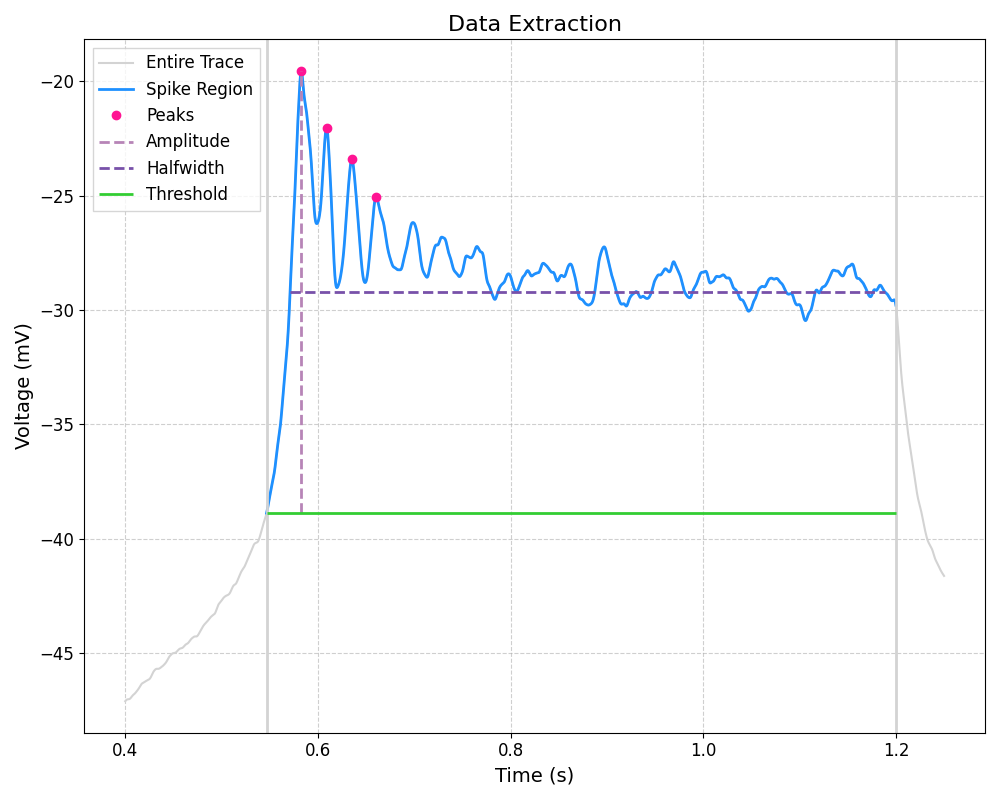

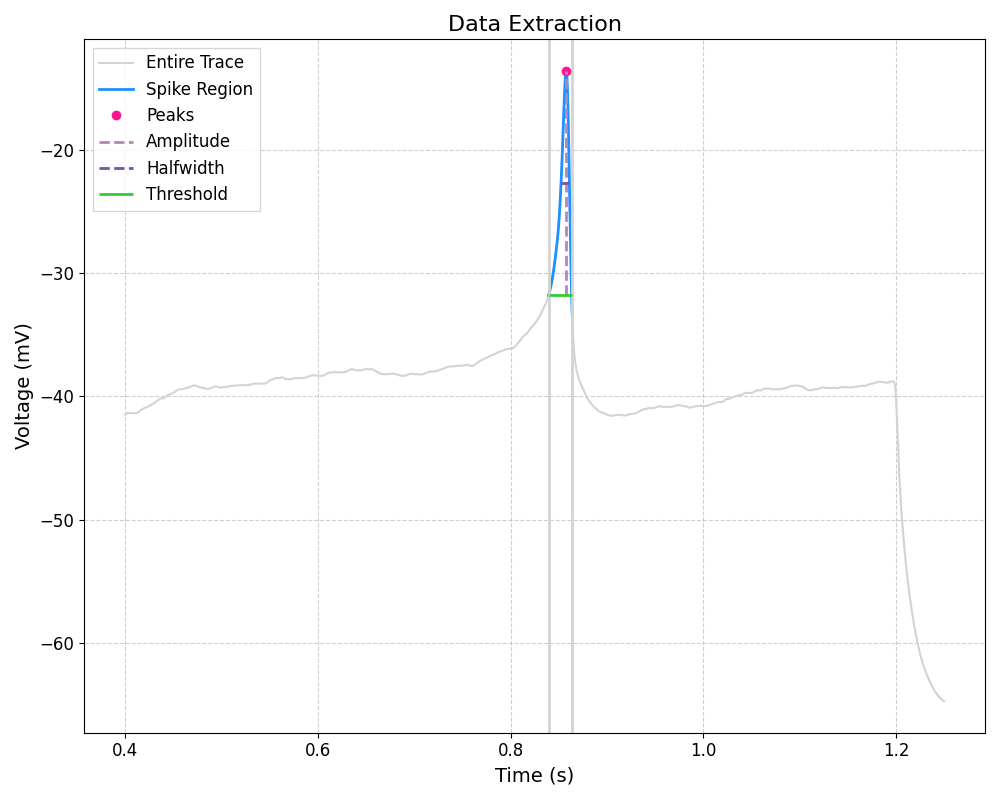

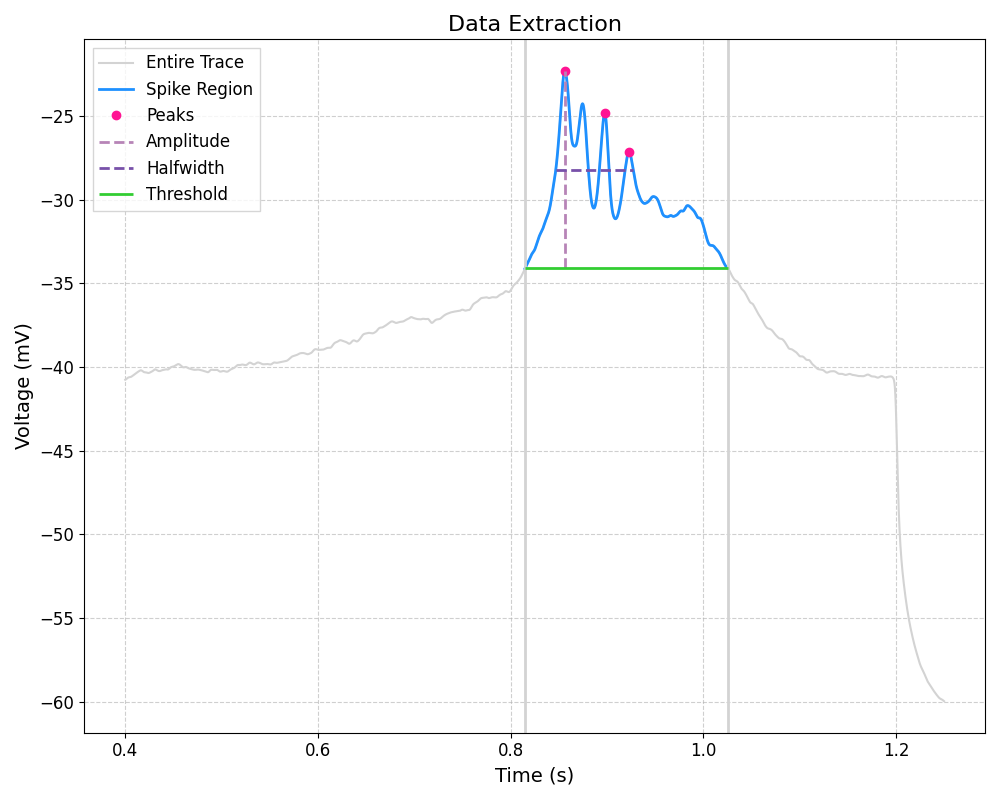

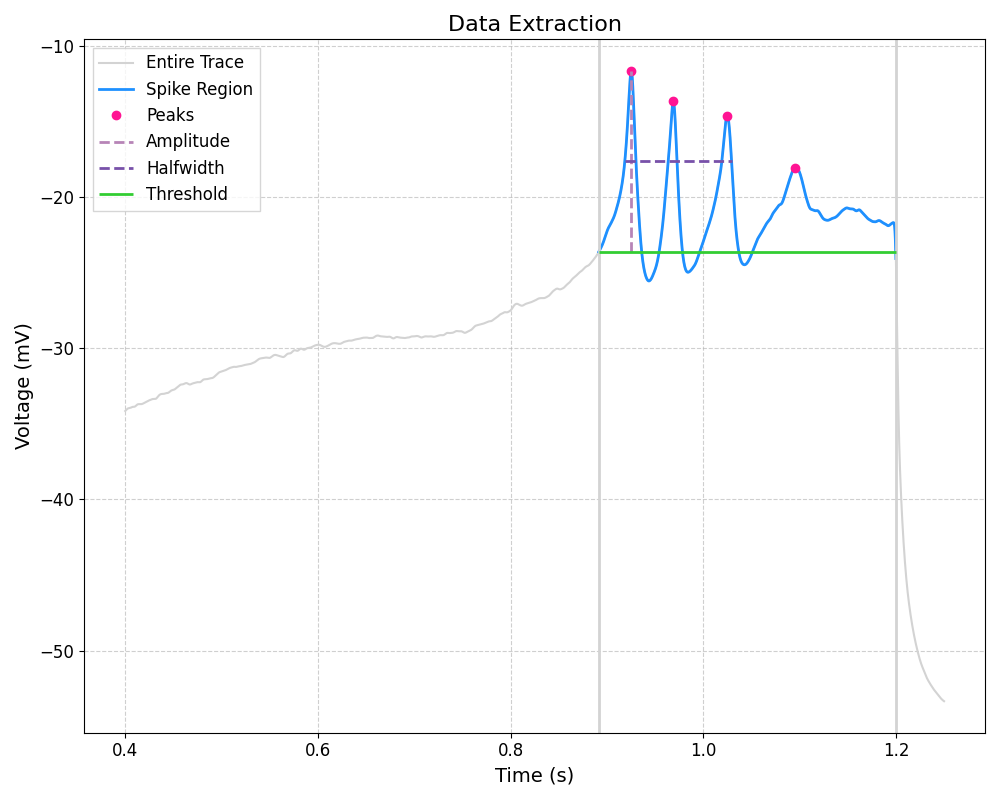

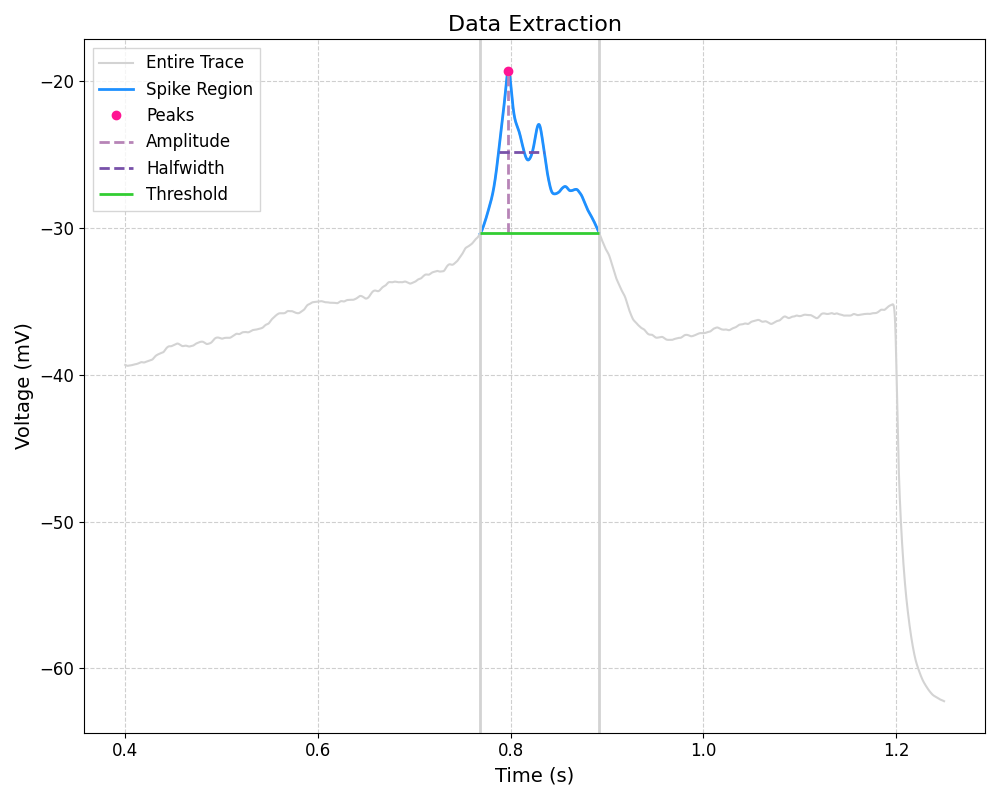

In [47]:
for f in files:
    print(f)
    the_trace = trace(f, sd= 0.00135, cell_localizer = False) #sd of gaussian filter can be changed- default is 0.0013
    fig, ax = plt.subplots(figsize=(10,8))
    the_trace.plot_trace(ax, save=False) #this function can be modified to plot different things- see function
    the_trace.print_summary()
    # simple_grapher(f, save=True)